In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [5]:
#!pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 27.5MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 43.5MB/s ta 0:00:01
Requirement not upgraded as not directly required: six>=1.10 in /home/nikhil_subscribed/anaconda3/lib/python3.7/site-packages (from kaggle) (1.11.0)
Requirement not upgraded as not directly required: certifi in /home/nikhil_subscribed/anaconda3/lib/python3.7/site-packages (from kaggle) (2018.8.24)
Requirement not upgraded as not directly required: python-dateutil in /home/nikhil_subscribed/anaconda3/lib/python3.7/site-packages (from kaggle) (2.7.3)
Requirement not upgraded as not directly required: requests in /home/nikhil_subscribed/anaconda3/lib/python3.7/site-packages (from kaggle) (2.19.1)
Requirement not upgraded as not directly required: tqdm in /home/nikhil_subscribed/anaconda3/lib/python3.7/site-packages (from kaggle) (4.26.0)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/nikhil_subscribed/anaconda3/lib/py

In [8]:
# !mkdir -p ~/.kaggle
# !mv ~/kaggle.json ~/.kaggle/

In [4]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/nikhil_subscribed/.fastai/data/planet')

In [13]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99%|████████████████████████████████████████▋| 596M/600M [00:04<00:00, 128MB/s]
100%|█████████████████████████████████████████| 600M/600M [00:04<00:00, 144MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 82.2MB/s]
/bin/sh: 1: unzip: not found


In [14]:
#! conda install -y -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /home/nikhil_subscribed/anaconda3

  added / updated specs: 
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         565 KB  haasad

The following NEW packages will be INSTALLED:

    eidl7zip: 1.0.0-1 haasad


eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [24]:
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [5]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [10]:
np.random.seed(42)
src = (ImageFileList.from_folder(path)
      .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2))

In [11]:
data = (src.datasets()
       .transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

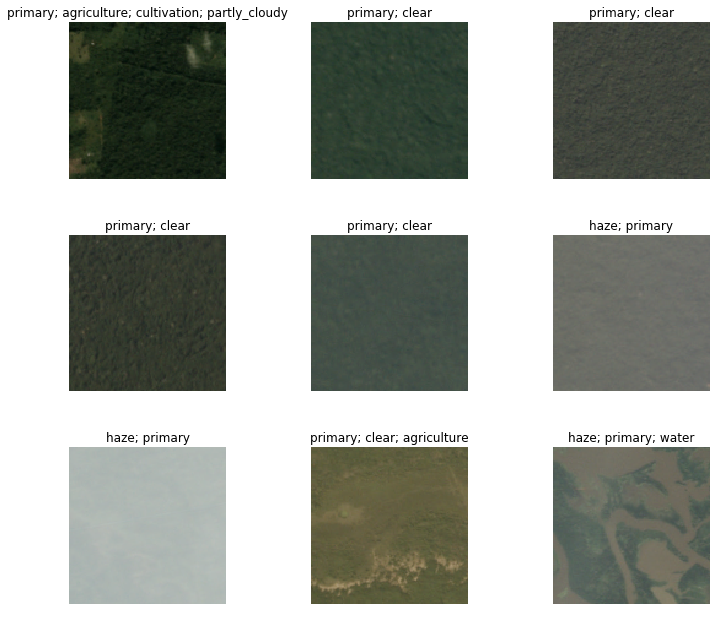

In [33]:
data.show_batch(rows=3, figsize=(10,9))

In [8]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh = 0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [36]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


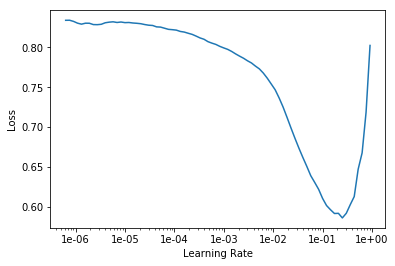

In [38]:
learn.recorder.plot()

In [39]:
lr = 0.01

In [45]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:17
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.115870    0.104284    0.950769         0.907607  (01:51)
2      0.110195    0.103456    0.952832         0.906312  (01:52)
3      0.101534    0.092469    0.952200         0.919880  (01:51)
4      0.097273    0.086086    0.953254         0.925921  (01:51)
5      0.088930    0.084631    0.957272         0.926632  (01:51)



In [46]:
learn.save('stage-1-rn50')

In [47]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


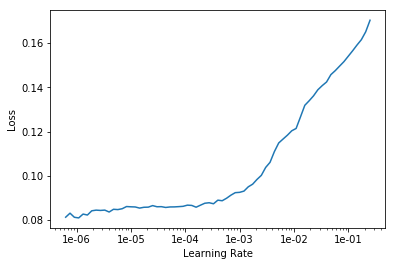

In [48]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 12:01
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.094540    0.090298    0.954489         0.919741  (02:23)
2      0.092987    0.089256    0.956204         0.925073  (02:24)
3      0.089140    0.086713    0.955826         0.924302  (02:25)
4      0.083389    0.082556    0.957628         0.928307  (02:24)
5      0.081491    0.081816    0.958994         0.929258  (02:22)



In [51]:
learn.save('stage-2-rn50')

In [13]:
learn.load('stage-2-rn50')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7fd6163c3898>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [14]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/home/nikhil_subscribed/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 256, 256])

In [15]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


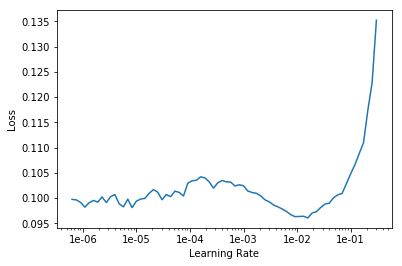

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr=1e-2/2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.085544,0.083723,0.959300,0.927144


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 7.43 GiB total capacity; 6.83 GiB already allocated; 2.94 MiB free; 109.38 MiB cached)

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))